### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import warnings

%matplotlib inline

### Reading Data

In [3]:
rest_data = pd.read_csv("C:/Users/aryan/OneDrive/Desktop/NYU DSGA3001/zomato.csv")

### Data Cleaning

##### Removing Duplicate Entries

In [4]:
rest_data = rest_data.drop_duplicates('url')

##### Removing menu_item as almost all columns are empty lists

In [5]:
rest_data.drop('menu_item',axis=1,inplace=True)

##### Checking for NaNs in relevant columns

In [6]:
#21 null values in location column 
rest_data['location'].isna().sum()

#227 null in rest_type
rest_data['rest_type'].isna().sum()

#20252 null in dish_liked, 28078 null values in dish_liked column without removing any others
rest_data['dish_liked'].isna().sum()

#11 null in dish_liked, 45 null values in dish_liked column without removing any others
rest_data['cuisines'].isna().sum()

#11 null, 45 null values in column without removing any others
rest_data['cuisines'].isna().sum()

#247 null, 346 null values column without removing any others
rest_data['approx_cost(for two people)'].isna().sum()

#0 null, 0 null values column without removing any others
rest_data['reviews_list'].isna().sum()

#'menu_item' dropped in dataset

#0 null, 0 null values column without removing any others
rest_data['listed_in(type)'].isna().sum()

print('We have checked for nulls in the relevant columns')

We have checked for nulls in the relevant columns


##### Dropping NaNs for columns where imputation would not make business sense/harm the problem statement

In [7]:
rest_data.dropna(subset=['rate','location','rest_type','cuisines','approx_cost(for two people)'],inplace=True)

In [8]:
rest_data = rest_data.reset_index()
rest_data.drop('index',axis=1,inplace=True)

In [9]:
#Data cleaning: 
#Change pricing and any other numerical columns to integers
#Change rate to single number (not x/5)

In [12]:
#Remove commas from the numbers in the approx_cost
rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].str.replace(',', '')

##### Extracting the rating from the 'rate' column (Getting 3.7 from "3.7/5")

In [13]:
rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].astype('Int64')

#Keep only the rating and convert to float (remove the '/5' for each entry)
rest_data['rate'] = rest_data['rate'].astype('str')

#Split string by '/'
rest_data['rate'] = rest_data['rate'].str.split('/').str[0]

#Convert to float
rest_data['rate'] = pd.to_numeric(rest_data['rate'], errors = 'coerce')

##### Making a normalized ratings column

In [14]:
ratings_mean = rest_data['rate'].mean()
ratings_std = rest_data['rate'].std()
rest_data['normalized_ratings'] = (rest_data['rate']-ratings_mean)/ratings_std

##### Making a column that counts the cuisines listed on the restaurant

In [15]:
cuisine_count = np.zeros(len(rest_data['cuisines']))

for i in range(len(rest_data['cuisines'])):
    cuisine_count[i] = len(rest_data['cuisines'][i].split(', '))
    
rest_data['cuisines_count'] = cuisine_count

In [16]:
print('The correlation between ratings and the number of cuisines offered is:',rest_data['rate'].corr(rest_data['cuisines_count']))

The correlation between ratings and the number of cuisines offered is: 0.20674347150298625


##### Making columns for cuisines offered at a restaurant (so the data becomes easier to read). The most amount of permitted cuisines on the site is 8, so we have columns from 'cuisine_1' to 'cuisine_8'

In [17]:
cuisine_list = []

for i in range(len(rest_data['cuisines'])):
    cuisine_list.append(rest_data['cuisines'][i].split(', ')) 

rest_data['cuisines_list'] = cuisine_list

In [18]:
rest_data[['cuisine_1', 'cuisine_2', 'cuisine_3','cuisine_4','cuisine_5','cuisine_6','cuisine_7','cuisine_8']] = rest_data['cuisines_list'].apply(
    lambda x: pd.Series([x[0], x[1] if len(x) > 1 else None, x[2] if len(x) > 2 else None, x[3] if len(x) > 3 else None,
                         x[4] if len(x) > 4 else None, x[5] if len(x) > 5 else None, x[6] if len(x) > 6 else None,
                         x[7] if len(x) > 7 else None])
)

##### Making a 'price_range' column that buckets the approx_cost_for_2 ('$','$$','$$$','$$$$')

In [19]:
rest_data['price_range'] = 0
rest_data.loc[rest_data['approx_cost(for two people)'] <= 250, 'price_range'] = '$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 250) & (rest_data['approx_cost(for two people)'] < 500), 'price_range'] = '$$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 500) & (rest_data['approx_cost(for two people)'] < 1000), 'price_range'] = '$$$'
rest_data.loc[rest_data['approx_cost(for two people)'] >= 1000, 'price_range'] = '$$$$'

### Data Exploration

#### Cuisine 

##### Finding the most popular cuisine based on the number of restaurants listed under that cuisine

In [20]:
rest_data_cuisine = rest_data.copy(deep=True)
rest_data_cuisine.fillna('NaN', inplace=True)
unique_cuisines = np.unique(rest_data_cuisine[['cuisine_1', 'cuisine_2', 'cuisine_3', 'cuisine_4', 'cuisine_5', 'cuisine_6', 'cuisine_7', 'cuisine_8']].values)
unique_cuisines = list(unique_cuisines)

In [21]:
cuisine_count_list = []
for i in range(len(unique_cuisines)):
    rows = rest_data[(rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])].index
    cuisine_df = rest_data.iloc[rows]
    cuisine_count_list.append(len(cuisine_df))
    df_name = '{}_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df

In [22]:
cuisine_popularity_df = pd.DataFrame()
cuisine_popularity_df['Cuisine'] = unique_cuisines
cuisine_popularity_df['Count'] = cuisine_count_list

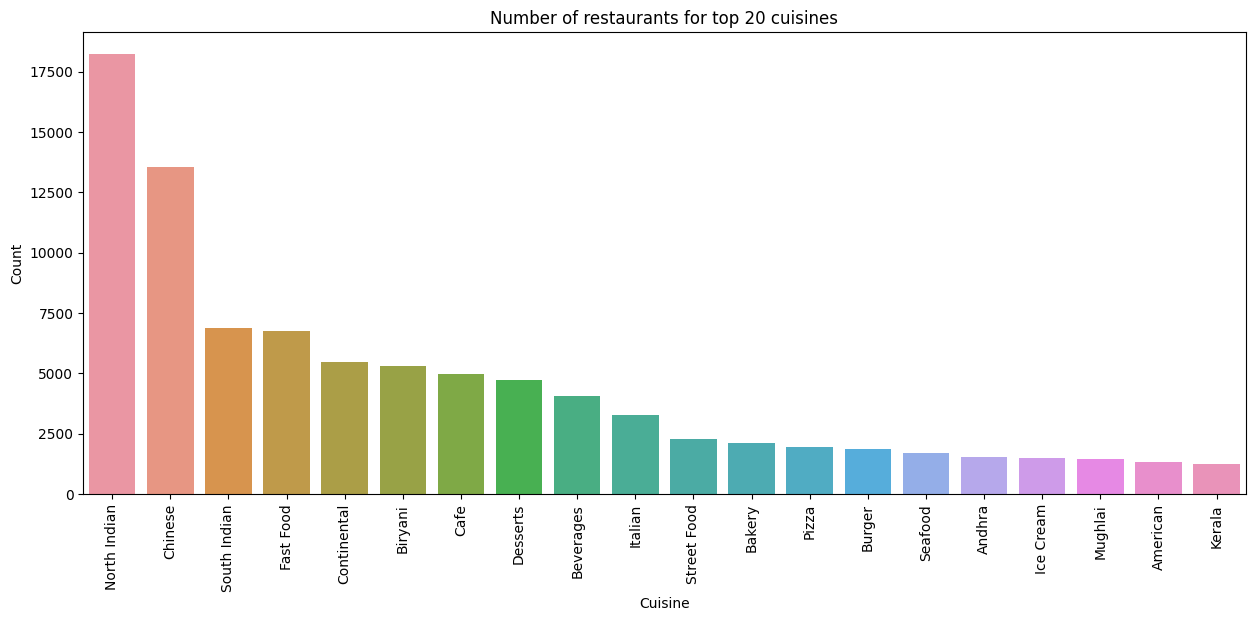

In [23]:
cuisine_popularity_df = cuisine_popularity_df.sort_values(by=['Count'], ascending=False)
cuisine_popularity_df = cuisine_popularity_df.reset_index()
cuisine_popularity_df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df[:20],x = 'Cuisine', y='Count')
plt.title('Number of restaurants for top 20 cuisines')
plt.xticks(rotation=90)
plt.show()

##### The graph below is plotted fromn the original cuisines column and we can see the difference in the results

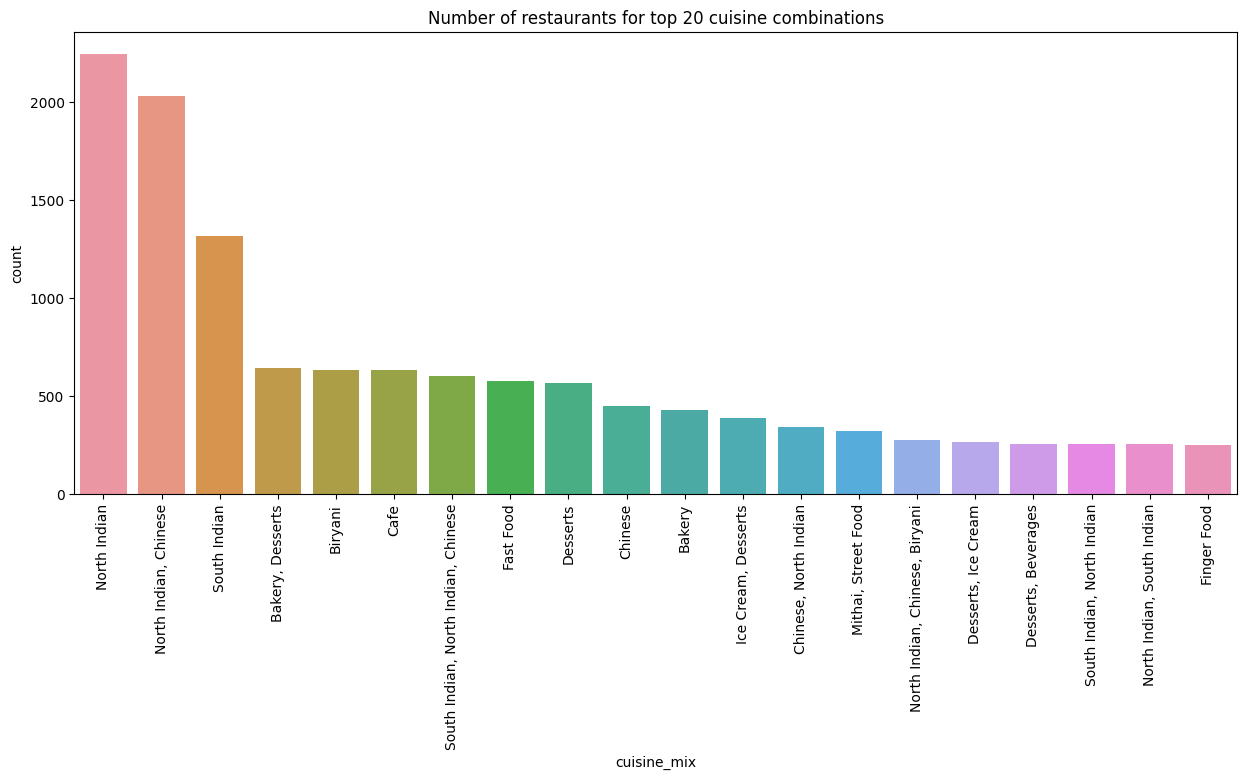

In [24]:
rest_data_mix_cuisine_top = rest_data['cuisines'].value_counts()[:20].rename_axis('cuisine_mix').reset_index(name='count')

plt.figure(figsize=(15,6))
sns.barplot(data=rest_data_mix_cuisine_top,x = 'cuisine_mix', y='count')
plt.title('Number of restaurants for top 20 cuisine combinations')
plt.xticks(rotation=90)
plt.show()

#### Now we look at the distribution of ratings across the top 20 cuisines

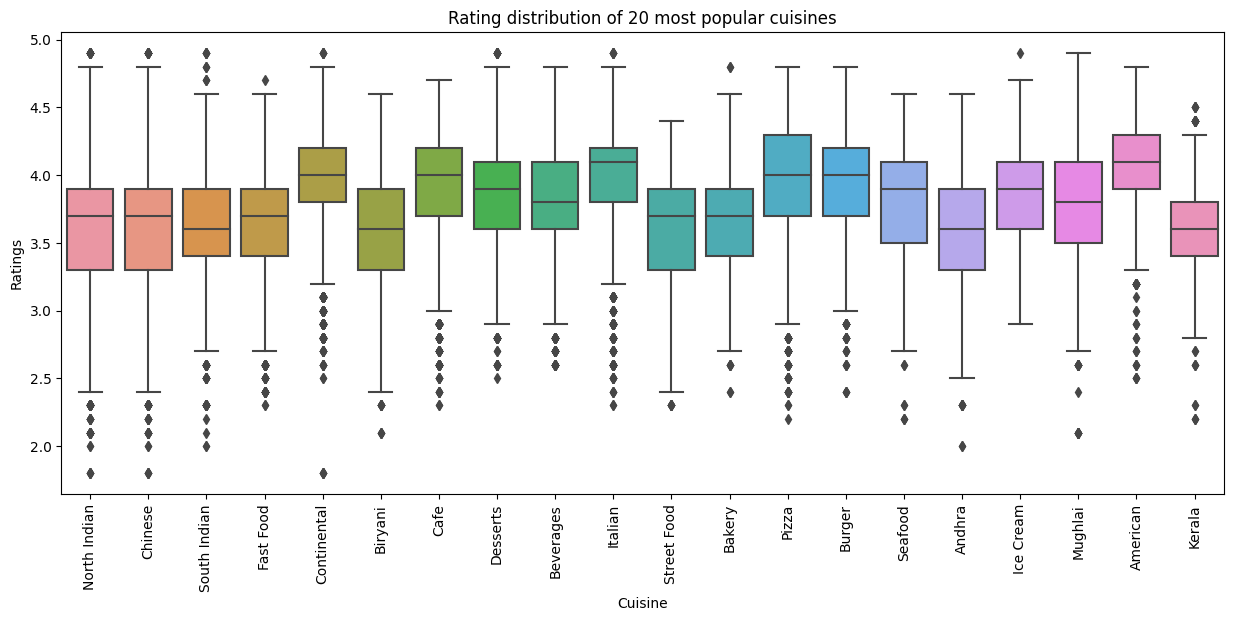

In [25]:
unique_cuisine_top = list(cuisine_popularity_df.head(20)['Cuisine'])
rate_data = []

for cuisine in unique_cuisine_top:
    cuisine_df = globals()['{}_df'.format(cuisine.replace(' ', ''))]
    rate_data.append(cuisine_df['rate'].dropna().tolist())

plt.figure(figsize=(15,6))
sns.boxplot(rate_data)

plt.xticks(range(0, len(unique_cuisine_top)), unique_cuisine_top, rotation=90)
plt.ylabel('Ratings')
plt.xlabel('Cuisine')
plt.title('Rating distribution of 20 most popular cuisines')
plt.show()

##### Distribution of votes across restaurants

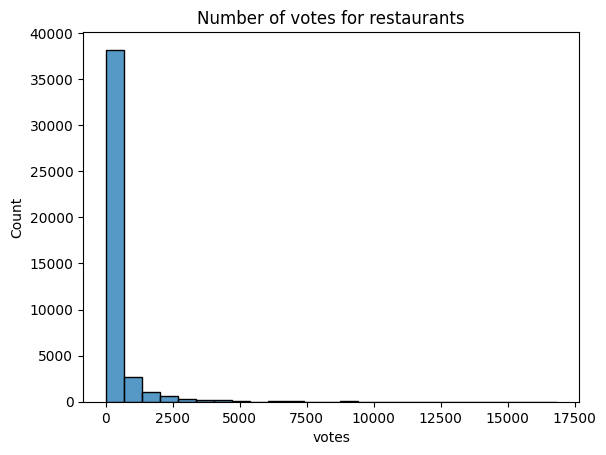

In [26]:
sns.histplot(rest_data['votes'],bins=25)
plt.title('Number of votes for restaurants')
plt.show()

### Building the Ideal Restaurant (Preliminary Approach)

In [27]:
#Aryan Approach
#Location: Most restaurants (Great place to set up as there is demand)
#Cuisine: Highest rated cuisine in that area
#Type: Highest rated type of restaurant in the area
#Budget: Highest rated 'budget-group'

#Mallory Approach
#Location: Highest rated location in the city
#Cuisine: Most popular cuisine in that location
#Type: Most popular type in that cuisine
#Budget: Most popular price_range in that budget

In [28]:
#Finds the location with most restaurants
location1 = rest_data['listed_in(city)'].value_counts().index[0]
location2 = rest_data.groupby('listed_in(city)')['rate'].mean().idxmax()


In [29]:
#Finds the relevant cuisines
cuisine1 = rest_data[rest_data['listed_in(city)'] == location1].groupby('cuisines')['rate'].mean().idxmax()
cuisine2 = rest_data[rest_data['listed_in(city)'] == location2]['cuisines'].value_counts().index[0]

In [30]:
#Finds the ideal restaurant types
type1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1)].groupby('listed_in(type)')['rate'].mean().idxmax()
type2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2)]['listed_in(type)'].value_counts().index[0]

In [31]:
#Finds the ideal price range
price_range1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1) & (rest_data['listed_in(type)'] == type1)].groupby('price_range')['rate'].mean().idxmax()
price_range2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2) & (rest_data['listed_in(type)'] == type2)]['price_range'].value_counts().index[0]

In [32]:
print('Our Preliminary Answers:\n')
print('Aryan:')
print('Location:',location1)
print('Cuisine:',cuisine1)
print('Type:',type1)
print('Price Range:',price_range1)
print('\n')
print('Mallory:')
print('Location:',location2)
print('Cuisine:',cuisine2)
print('Type:',type2)
print('Price Range:',price_range2)

Our Preliminary Answers:

Aryan:
Location: BTM
Cuisine: Asian, Chinese, Thai, Momos
Type: Buffet
Price Range: $$$$


Mallory:
Location: Church Street
Cuisine: North Indian
Type: Delivery
Price Range: $$


##### These are the 4 highest restaurants (all rated 4.9) in Bangalore (sorted by votes)
###### Byg Brewski Brewing Company - Sarjapur Road - Continental, North Indian, Italian, South Indian, Finger Food - Drinks & Nightlife - $$$$
###### Absolute Barbecues - European, Mediterranean, North Indian, BBQ - Kormangala 7th Block - Buffet - $$$$
###### Flechazgo - White Field - Asian, Mediterranean, North Indian, BBQ - Dine Out - $$$$
###### Asia Kitchen - Koramangala 7th Block - Asian, Chinese, Thai, Momos - Dine Out - $$$$

We see that there is significant variance in the 4 restaurants (except the price range being $$$$), therefore this highlights the issue of there not being a direct answer to this problem statement. This is something that we need to keep in consideration throughout that project that there is no one-size-fits all restaurant that is going to be successful. 

##### Finding the 90th perecentile of rating to define a "successful restaurant rating" for our success metric in the later stages of project

In [33]:
rest_data['rate'].quantile(0.9)

4.2

#### Cuisine Hunt

In [34]:
rest_data['name'] = rest_data['name'].astype("string")
rest_data['address'] = rest_data['address'].astype("string")
rest_data['url'] = rest_data['url'].astype("string")
rest_data['online_order'] = rest_data['online_order'].astype("string")
rest_data['book_table'] = rest_data['book_table'].astype("string")
rest_data['phone'] = rest_data['phone'].astype("string")
rest_data['location'] = rest_data['location'].astype("string")
rest_data['rest_type'] = rest_data['rest_type'].astype("string")
rest_data['dish_liked'] = rest_data['dish_liked'].astype("string")
rest_data['cuisines'] = rest_data['cuisines'].astype("string")
rest_data['reviews_list'] = rest_data['reviews_list'].astype("string")
rest_data['listed_in(type)'] = rest_data['listed_in(type)'].astype("string")
rest_data['listed_in(city)'] = rest_data['listed_in(city)'].astype("string")
rest_data['cuisines_list'] = rest_data['cuisines_list'].astype("string")
rest_data['cuisine_1'] = rest_data['cuisine_1'].astype("string")
rest_data['cuisine_2'] = rest_data['cuisine_2'].astype("string")
rest_data['cuisine_3'] = rest_data['cuisine_3'].astype("string")
rest_data['cuisine_4'] = rest_data['cuisine_4'].astype("string")
rest_data['cuisine_5'] = rest_data['cuisine_5'].astype("string")
rest_data['cuisine_6'] = rest_data['cuisine_6'].astype("string")
rest_data['cuisine_7'] = rest_data['cuisine_7'].astype("string")
rest_data['cuisine_8'] = rest_data['cuisine_8'].astype("string")
rest_data['price_range'] = rest_data['price_range'].astype("string")

We observe in the data that each restaurant has multiple entries. For example if restaurant A has Buffet, Dineout and Delivery and delivers to 2 locations (Jayanagar, JP nagar) then it will have 6 (3*2) rows.
This would lead to a biased dataset as restaurants that offer differnt types and deliver to a lot of locations will dominate the findings.

To avoid this, we create a new dataframe that has only 1 row per restaurant.

In [86]:
pivot_df = rest_data.pivot_table(index=['address','name','location','rate','cuisines','price_range','approx_cost(for two people)'], columns='listed_in(type)', aggfunc='count', fill_value=0)
pivot_df.columns = pivot_df.columns.get_level_values(1)
listed_in_type_df = pivot_df.reset_index()

In [87]:
res_type_df = listed_in_type_df.iloc [:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

In [95]:
print("The median rating from the new dataset is:",res_type_df['rate'].median())
print("The median rating from the original dataset is:",rest_data['rate'].median())

The median rating from the new dataset is: 4.1
The median rating from the original dataset is: 3.7


We see that the median ratings differ, so we can say that lower rated restaurants were delivering to more locations and/or were listed under multiple restaurant types.

In [37]:
#del_df = res_type_df[(res_type_df['Delivery'] > res_type_df['Buffet']) & (res_type_df['Delivery'] > res_type_df['Cafes']) & (res_type_df['Delivery'] > res_type_df['Desserts']) & (res_type_df['Delivery'] > res_type_df['Dine-out']) & (res_type_df['Delivery'] > res_type_df['Drinks & nightlife']) & res_type_df['Delivery'] > res_type_df['Pubs and bars']]

In [89]:
col_for_conversion = ['Buffet','Cafes','Delivery','Drinks & nightlife','Dine-out','Pubs and bars','Desserts']
res_type_df[col_for_conversion] = res_type_df[col_for_conversion].applymap(lambda x: 1 if x >= 1 else 0)

C:\Users\aryan\AppData\Local\Temp\ipykernel_16092\3066083276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_type_df[col_for_conversion] = res_type_df[col_for_conversion].applymap(lambda x: 1 if x >= 1 else 0)


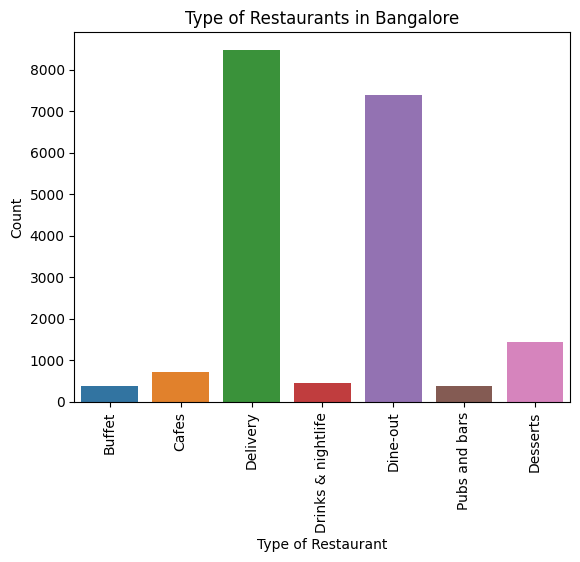

In [90]:
res_type_df_plot = res_type_df[col_for_conversion]

sum_of_1s = res_type_df_plot.sum(axis=0)
sns.barplot(x = col_for_conversion, y = sum_of_1s)

plt.xlabel('Type of Restaurant')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Type of Restaurants in Bangalore')
plt.show()

We see that Delivery and Dine-Out dominate as these are more broader categories when compared to others. Among the more specific categories, we see that Bangalore has a considerable amount of "Dessert" restaurants.

It is important to note that a restaurant listed as "Cafe" would also fall under "Dine-Out" (and possibly "Delivery"). Additionally, we also have restaurants that are more generic that would just be listed as "Dine-Out"

In [91]:
Buffet_df = res_type_df[res_type_df['Buffet']==1].iloc[:,[0,1,2,3,4,5,6]]
Cafes_df = res_type_df[res_type_df['Cafes']==1].iloc[:,[0,1,2,3,4,5,6]]
Dessert_df = res_type_df[res_type_df['Desserts']==1].iloc[:,[0,1,2,3,4,5,6]]
Dineout_df = res_type_df[res_type_df['Dine-out']==1].iloc[:,[0,1,2,3,4,5,6]]
DrinksAndNightlife_df = res_type_df[res_type_df['Drinks & nightlife']==1].iloc[:,[0,1,2,3,4,5,6]]
PubsAndBars_df = res_type_df[res_type_df['Pubs and bars']==1].iloc[:,[0,1,2,3,4,5,6]]

Buffet_df = Buffet_df.iloc[:,[0,1,2,3,4,5,6]]
Cafes_df = Cafes_df.iloc[:,[0,1,2,3,4,5,6]]
Dessert_df = Dessert_df.iloc[:,[0,1,2,3,4,5,6]]
Dineout_df = Dineout_df.iloc[:,[0,1,2,3,4,5,6]]
DrinksAndNightlife_df = DrinksAndNightlife_df.iloc[:,[0,1,2,3,4,5,6]]
PubsAndBars_df = PubsAndBars_df.iloc[:,[0,1,2,3,4,5,6]]


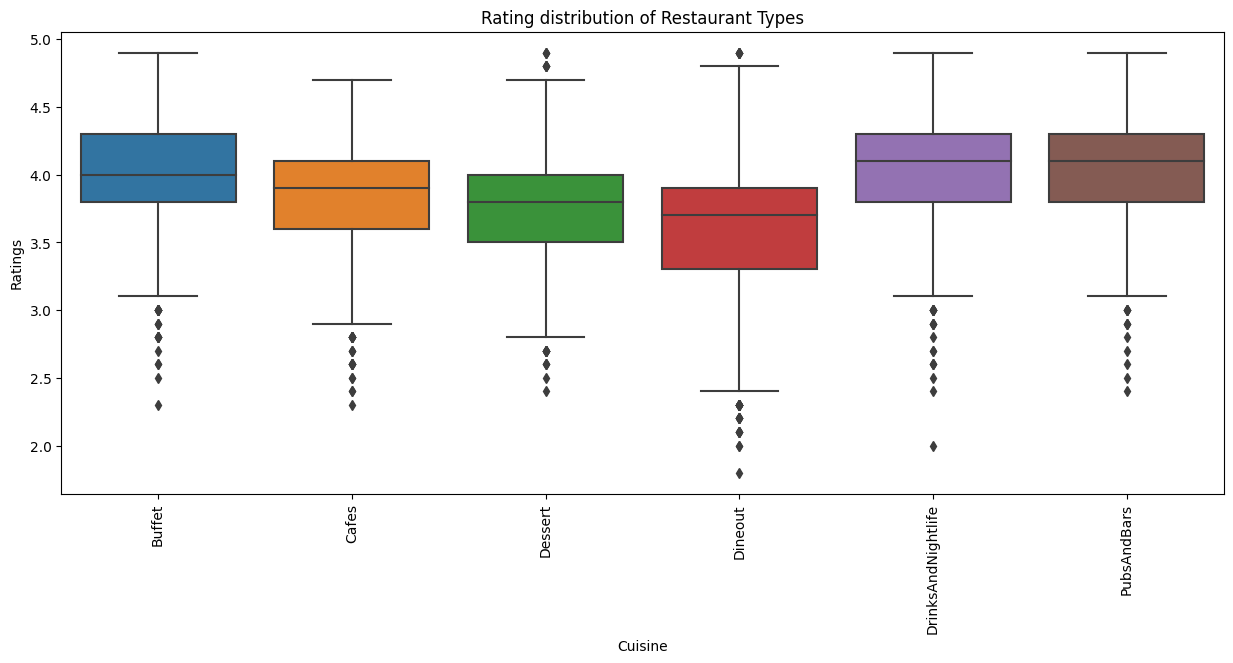

In [92]:
rate_type_data = []
res_type_list = ['Buffet','Cafes','Dessert','Dineout','DrinksAndNightlife','PubsAndBars']

for type in res_type_list:
    res_type_df = globals()['{}_df'.format(type.replace(' ', ''))]
    rate_type_data.append(res_type_df['rate'].dropna().tolist())

plt.figure(figsize=(15,6))
sns.boxplot(rate_type_data)

plt.xticks(range(0, len(res_type_list)), res_type_list, rotation=90)
plt.ylabel('Ratings')
plt.xlabel('Cuisine')
plt.title('Rating distribution of Restaurant Types')
plt.show()

# CORRECT HERE

Some important observations we make:
1. Buffets and Cafes are generally rated higher than other restaurant types.
2. Drinks&Nightlife and Pubs&Bars have very similar distributions which could be possibly because both could be used almost interchangebly in most scenarios (We would confirm this hypothesis later down the line using statistical tests).
3. Even though Desserts are a common restaurant type they do not fare as well with the population.

#### Confounder Analysis

Between the 2 top rated restaurant types (Buffets and Cafes), we would like to choose one. For this we look at any potential confounders that could be there that could be bringing upon these higher ratings and can they be accounted for.

##### The confounder that we want to account for is: Approx cost for 2